Training MAML on cpu...
Epoch 200/2000 - Meta Loss: 0.2929
Epoch 400/2000 - Meta Loss: 0.2529
Epoch 600/2000 - Meta Loss: 0.2857
Epoch 800/2000 - Meta Loss: 0.2705
Epoch 1000/2000 - Meta Loss: 0.2722
Epoch 1200/2000 - Meta Loss: 0.2636
Epoch 1400/2000 - Meta Loss: 0.2427
Epoch 1600/2000 - Meta Loss: 0.2357
Epoch 1800/2000 - Meta Loss: 0.2253
Epoch 2000/2000 - Meta Loss: 0.2390

Training Baseline (Joint Training) on cpu...
Epoch 200/2000 - Loss: 0.2954
Epoch 400/2000 - Loss: 0.2788
Epoch 600/2000 - Loss: 0.2896
Epoch 800/2000 - Loss: 0.2934
Epoch 1000/2000 - Loss: 0.3066
Epoch 1200/2000 - Loss: 0.3469
Epoch 1400/2000 - Loss: 0.2876
Epoch 1600/2000 - Loss: 0.3427
Epoch 1800/2000 - Loss: 0.3215
Epoch 2000/2000 - Loss: 0.3038

Generating Deliverables...


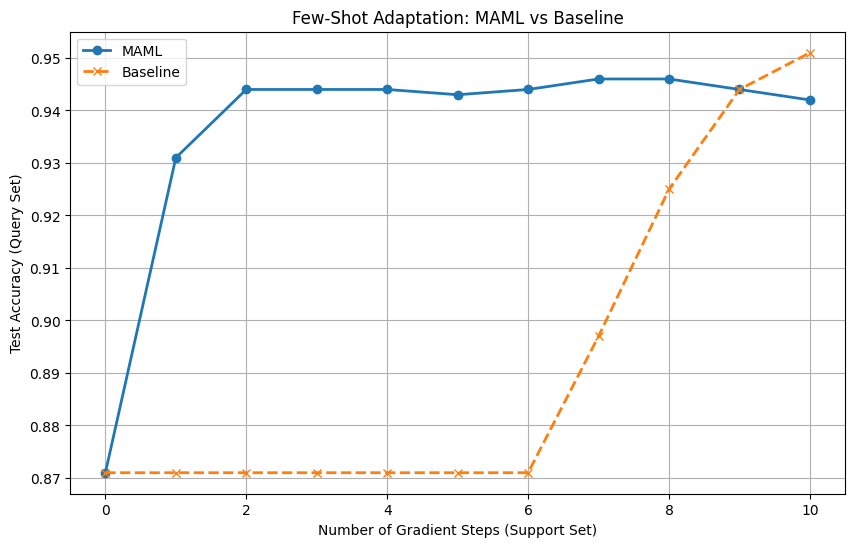

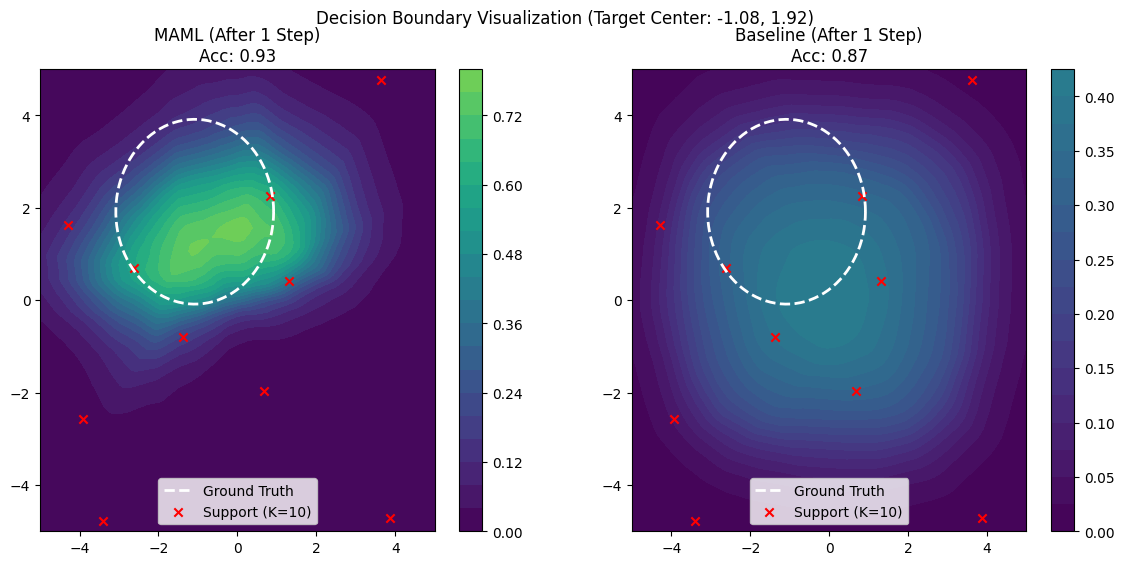

In [2]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
import numpy as np
import matplotlib.pyplot as plt
import copy

CONFIG = {
    'radius':2.0,            # Fixed radius r=2.0
    'x_range':(-5,5),       # Input space [-5,5]
    'center_range':(-3,3),  # Center sampled from [-3,3]
    'k_support':10,          # K=10 labeled examples
    'k_query':100,           # Size of query set for meta-update
    'meta_lr':0.001,         # Outer loop learning rate
    'inner_lr':0.4,          # Inner loop learning rate(high for fast adaptation)
    'epochs':2000,           # 2000 epochs as requested
    'meta_batch_size': 32,    # Tasks per outer loop step
    'device': 'cuda' if torch.cuda.is_available() else 'cpu'
}

def sample_task():
    """Sample a random center (cx, cy) for a task."""
    cx=np.random.uniform(*CONFIG['center_range'])
    cy=np.random.uniform(*CONFIG['center_range'])
    return cx, cy

def get_data(cx, cy, num_points):
    """Generate x data and y labels for a specific circular boundary."""
    x=torch.rand(num_points, 2)*(CONFIG['x_range'][1] - CONFIG['x_range'][0])+CONFIG['x_range'][0]

    dist = torch.sqrt((x[:, 0] - cx)**2 + (x[:, 1] - cy)**2)
    y = (dist < CONFIG['radius']).float().unsqueeze(1)

    return x.to(CONFIG['device']), y.to(CONFIG['device'])
class SimpleMLP(nn.Module):
    """A simple 3-layer MLP for 2D classification."""
    def __init__(self):
        super(SimpleMLP, self).__init__()
        self.net = nn.Sequential(
            nn.Linear(2, 64),
            nn.ReLU(),
            nn.Linear(64, 64),
            nn.ReLU(),
            nn.Linear(64, 1)
        )

    def forward(self, x):
        return self.net(x)

def functional_forward(x, params):
    """
    Manual forward pass using specific parameters (dictionary)
    instead of the model's internal state.
    """
    x=F.linear(x,params['net.0.weight'],params['net.0.bias'])
    x=F.relu(x)
    x=F.linear(x,params['net.2.weight'],params['net.2.bias'])
    x=F.relu(x)
    x=F.linear(x,params['net.4.weight'],params['net.4.bias'])
    return x

# MAML Implementation
def train_maml():
    print(f"Training MAML on {CONFIG['device']}...")
    model=SimpleMLP().to(CONFIG['device'])
    meta_optimizer=optim.Adam(model.parameters(),lr=CONFIG['meta_lr'])

    loss_history=[]
    for epoch in range(CONFIG['epochs']):
        meta_optimizer.zero_grad()
        meta_loss=0.0

        for _ in range(CONFIG['meta_batch_size']):
            cx, cy = sample_task()

            x_s, y_s=get_data(cx, cy, CONFIG['k_support'])
            x_q, y_q = get_data(cx, cy, CONFIG['k_query'])
            params=dict(model.named_parameters())

            preds=functional_forward(x_s, params)
            loss=F.binary_cross_entropy_with_logits(preds, y_s)
            grads=torch.autograd.grad(loss,params.values(),create_graph=True)

            updated_params = {}
            for (name, param), grad in zip(params.items(), grads):
                updated_params[name] = param - CONFIG['inner_lr'] * grad

            q_preds = functional_forward(x_q, updated_params)
            q_loss = F.binary_cross_entropy_with_logits(q_preds, y_q)
            meta_loss += q_loss
        meta_loss /= CONFIG['meta_batch_size']
        meta_loss.backward()
        meta_optimizer.step()

        loss_history.append(meta_loss.item())
        if (epoch+1) % 200 == 0:
            print(f"Epoch {epoch+1}/{CONFIG['epochs']} - Meta Loss: {meta_loss.item():.4f}")

    return model

# Baseline (Joint Trainin)
def train_baseline():
    print(f"\nTraining Baseline (Joint Training) on {CONFIG['device']}...")
    model=SimpleMLP().to(CONFIG['device'])
    optimizer=optim.Adam(model.parameters(), lr=CONFIG['meta_lr'])

    for epoch in range(CONFIG['epochs']):
        optimizer.zero_grad()

        batch_x= []
        batch_y=[]
        for _ in range(CONFIG['meta_batch_size']):
            cx,cy=sample_task()
            x, y =get_data(cx, cy, CONFIG['k_support'])
            batch_x.append(x)
            batch_y.append(y)

        batch_x=torch.cat(batch_x)
        batch_y=torch.cat(batch_y)

        preds=model(batch_x)
        loss=F.binary_cross_entropy_with_logits(preds, batch_y)

        loss.backward()
        optimizer.step()
        if (epoch+1) % 200 == 0:
            print(f"Epoch {epoch+1}/{CONFIG['epochs']} - Loss: {loss.item():.4f}")

    return model

def fine_tune_and_evaluate(model, x_s, y_s, x_q, y_q, steps=10, is_maml=False):
    """
    Fine-tunes a model on x_s/y_s for `steps` and evaluates accuracy on x_q/y_q.
    Returns a list of accuracies [step0, step1, ... stepN].
    """
    accuracies = []
    if is_maml:

        params=dict(model.named_parameters())
        with torch.no_grad():
            preds=functional_forward(x_q, params)
            acc=((torch.sigmoid(preds) > 0.5) == y_q).float().mean().item()
            accuracies.append(acc)

        curr_params=params
        for _ in range(steps):

            preds = functional_forward(x_s, curr_params)
            loss = F.binary_cross_entropy_with_logits(preds, y_s)

            grads = torch.autograd.grad(loss, curr_params.values())

            new_params = {}
            for (name, p), g in zip(curr_params.items(), grads):
                new_params[name]=p-CONFIG['inner_lr']*g
            curr_params=new_params

            with torch.no_grad():
                q_preds=functional_forward(x_q, curr_params)
                acc=((torch.sigmoid(q_preds) > 0.5) == y_q).float().mean().item()
                accuracies.append(acc)

        return accuracies, curr_params
    else:

        ft_model=copy.deepcopy(model)
        ft_optimizer= optim.SGD(ft_model.parameters(), lr=CONFIG['inner_lr'])

        with torch.no_grad():
            preds=ft_model(x_q)
            acc=((torch.sigmoid(preds) > 0.5) == y_q).float().mean().item()
            accuracies.append(acc)

        for _ in range(steps):
            ft_optimizer.zero_grad()
            preds=ft_model(x_s)
            loss=F.binary_cross_entropy_with_logits(preds, y_s)
            loss.backward()
            ft_optimizer.step()

            with torch.no_grad():
                q_preds = ft_model(x_q)
                acc=((torch.sigmoid(q_preds) > 0.5) == y_q).float().mean().item()
                accuracies.append(acc)

        return accuracies, ft_model

# Delivrable Generation
def generate_deliverables(maml_model, baseline_model):
    print("\nGenerating Deliverables...")

    test_cx, test_cy = sample_task()
    x_s, y_s=get_data(test_cx, test_cy, CONFIG['k_support'])
    x_q, y_q=get_data(test_cx, test_cy, 1000)

    # Quantitative: Accuracy vs Steps
    maml_accs, maml_params_final = fine_tune_and_evaluate(maml_model, x_s, y_s, x_q, y_q, steps=10, is_maml=True)
    base_accs, base_model_final = fine_tune_and_evaluate(baseline_model, x_s, y_s, x_q, y_q, steps=10, is_maml=False)

    plt.figure(figsize=(10, 6))
    plt.plot(range(11), maml_accs, 'o-', label='MAML', linewidth=2)
    plt.plot(range(11), base_accs, 'x--', label='Baseline', linewidth=2)
    plt.xlabel('Number of Gradient Steps (Support Set)')
    plt.ylabel('Test Accuracy (Query Set)')
    plt.title('Few-Shot Adaptation: MAML vs Baseline')
    plt.legend()
    plt.grid(True)
    plt.savefig('accuracy_vs_steps.png')
    plt.show()

    # Qualitative: Heatmaps

    grid_size = 100
    x=np.linspace(-5, 5, grid_size)
    y=np.linspace(-5, 5, grid_size)
    xx, yy = np.meshgrid(x, y)
    grid_tensor = torch.FloatTensor(np.c_[xx.ravel(), yy.ravel()]).to(CONFIG['device'])

    _, maml_1step_params=fine_tune_and_evaluate(maml_model, x_s, y_s, x_q, y_q, steps=1, is_maml=True)
    _, base_1step_model=fine_tune_and_evaluate(baseline_model, x_s, y_s, x_q, y_q, steps=1, is_maml=False)

    with torch.no_grad():
        # MAML
        maml_z=functional_forward(grid_tensor, maml_1step_params)
        maml_prob=torch.sigmoid(maml_z).reshape(grid_size, grid_size).cpu().numpy()

        # baseline
        base_z=base_1step_model(grid_tensor)
        base_prob=torch.sigmoid(base_z).reshape(grid_size, grid_size).cpu().numpy()

    fig, axes = plt.subplots(1, 2, figsize=(14, 6))

    theta = np.linspace(0, 2*np.pi, 100)
    circle_x = test_cx + CONFIG['radius'] * np.cos(theta)
    circle_y = test_cy + CONFIG['radius'] * np.sin(theta)

    # MAML plot
    c1 = axes[0].contourf(xx, yy, maml_prob, levels=20, cmap='viridis', vmin=0, vmax=1)
    axes[0].plot(circle_x, circle_y, 'w--', linewidth=2, label='Ground Truth')
    axes[0].scatter(x_s[:,0].cpu(), x_s[:,1].cpu(), c='red', marker='x', label='Support (K=10)')
    axes[0].set_title(f"MAML (After 1 Step)\nAcc: {maml_accs[1]:.2f}")
    axes[0].legend()

    # baseline plot
    c2 = axes[1].contourf(xx, yy, base_prob, levels=20, cmap='viridis', vmin=0, vmax=1)
    axes[1].plot(circle_x, circle_y, 'w--', linewidth=2, label='Ground Truth')
    axes[1].scatter(x_s[:,0].cpu(), x_s[:,1].cpu(), c='red', marker='x', label='Support (K=10)')
    axes[1].set_title(f"Baseline (After 1 Step)\nAcc: {base_accs[1]:.2f}")
    axes[1].legend()

    plt.colorbar(c1,ax=axes[0])
    plt.colorbar(c2,ax=axes[1])
    plt.suptitle(f'Decision Boundary Visualization (Target Center: {test_cx:.2f}, {test_cy:.2f})')
    plt.savefig('heatmaps.png')
    plt.show()

# main execution
if __name__=="__main__":

    maml_model=train_maml()
    baseline_model=train_baseline()
    generate_deliverables(maml_model,baseline_model)